In [15]:
import os
from os.path import join
import re
import tarfile
from functools import reduce

import numpy as np
from nltk import FreqDist
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
path = get_file("babi-tasks-v1-2.tar.gz", origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')

In [3]:
with tarfile.open(path) as tar:
    tar.extractall()
    tar.close()
    
DATA_DIR   = 'tasks_1-20_v1-2/en-10k'
TRAIN_FILE = join(DATA_DIR, "qa1_single-supporting-fact_train.txt")
TEST_FILE  = join(DATA_DIR, "qa1_single-supporting-fact_test.txt")

In [4]:
i = 0
lines = open(TRAIN_FILE, "rb")
for line in lines:
    line = line.decode('utf-8').strip()
    
    i += 1
    print(line)
    if i == 20:
        break

1 Mary moved to the bathroom.
2 John went to the hallway.
3 Where is Mary? 	bathroom	1
4 Daniel went back to the hallway.
5 Sandra moved to the garden.
6 Where is Daniel? 	hallway	4
7 John moved to the office.
8 Sandra journeyed to the bathroom.
9 Where is Daniel? 	hallway	4
10 Mary moved to the hallway.
11 Daniel travelled to the office.
12 Where is Daniel? 	office	11
13 John went back to the garden.
14 John moved to the bedroom.
15 Where is Sandra? 	bathroom	8
1 Sandra travelled to the office.
2 Sandra went to the bathroom.
3 Where is Sandra? 	bathroom	2
4 Mary went to the bedroom.
5 Daniel moved to the hallway.


In [5]:
def read_data(dir):
    stories, questions, answers = [], [], []
    story_temp = []
    lines = open(dir, "rb")
    
    for line in lines:
        line = line.decode('utf-8').strip()
        idx, text = line.split(" ", 1)
        
        if int(idx) == 1:
            story_temp = []
        
        if '\t' in text:
            question, answer, _ = text.split('\t')  # except supporting fact
            stories.append([x for x in story_temp if x])
            questions.append(question)
            answers.append(answer)
        else:
            story_temp.append(text)
    
    lines.close()
    return stories, questions, answers

In [6]:
train_stories, train_questions, train_answers = train_data = read_data(TRAIN_FILE)
test_stories,  test_questions,  test_answers  = test_data  = read_data(TEST_FILE)

In [7]:
print('훈련용 스토리의 개수 :', len(train_stories))
print('훈련용 질문의 개수 :',len(train_questions))
print('훈련용 답변의 개수 :',len(train_answers))
print('테스트용 스토리의 개수 :',len(test_stories))
print('테스트용 질문의 개수 :',len(test_questions))
print('테스트용 답변의 개수 :',len(test_answers))

훈련용 스토리의 개수 : 10000
훈련용 질문의 개수 : 10000
훈련용 답변의 개수 : 10000
테스트용 스토리의 개수 : 1000
테스트용 질문의 개수 : 1000
테스트용 답변의 개수 : 1000


In [8]:
train_stories[3576]

['John went back to the garden.',
 'Mary went to the kitchen.',
 'Sandra went back to the bedroom.',
 'John travelled to the bedroom.']

In [9]:
train_questions[3576]

'Where is John? '

In [10]:
train_answers[3576]

'bedroom'

In [11]:
def tokenize(sent):
    return [x.strip() for x in re.split("(\W+)", sent) if x.strip()]

# concatenate sentences in a story
flatten = lambda data: reduce(lambda x, y: x+y, data)

def preprocess_data(train_data, test_data):
    counter = FreqDist()

    story_len    = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story))  # words
            story_len.append(len(stories))      # number of words
            for word in stories:
                counter[word] += 1
        
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1
    
    word2idx = {word: (1+idx) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx: word for word, idx in word2idx.items()}
    
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)
    
    return word2idx, idx2word, story_max_len, question_max_len

In [12]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [13]:
vocab_size = len(word2idx) + 1

In [14]:
word2idx

{'to': 1,
 'the': 2,
 '.': 3,
 'went': 4,
 'Sandra': 5,
 'John': 6,
 'Daniel': 7,
 'Mary': 8,
 'travelled': 9,
 'journeyed': 10,
 'back': 11,
 'bathroom': 12,
 'garden': 13,
 'hallway': 14,
 'moved': 15,
 'office': 16,
 'kitchen': 17,
 'bedroom': 18,
 'Where': 19,
 'is': 20,
 '?': 21}

In [15]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 68
질문의 최대 길이 : 4


In [16]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    
    for story, question, answer in zip(*data):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(flatten(question))]
        Xs.append(xs), Xq.append(xq)
        Y.append(word2idx[answer])
    
    return pad_sequences(Xs, maxlen=story_maxlen), pad_sequences(Xq, maxlen=question_maxlen), to_categorical(Y, num_classes=len(word2idx)+1)

In [17]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [18]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 68) (10000, 4) (10000, 22) (1000, 68) (1000, 4) (1000, 22)


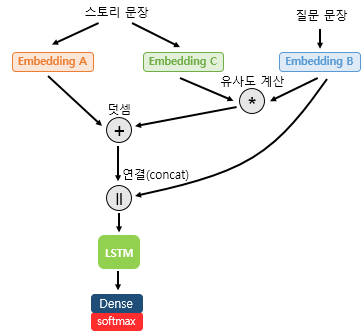

In [ ]:
S  = [N, maxlen_story,    vocab_size] -> [N, maxlen_story,    embed_size]
Q  = [N, maxlen_question, vocab_size] -> [N, maxlen_question, embed_size]

C  = [N, maxlen_story, maxlen_question] -> [N, maxlen_story, maxlen_question] (softmax)
S2 = [N, maxlen_story,    vocab_size]   -> [N, maxlen_story, maxlen_question] (embeding)


S2 = [N, maxlen_story,    vocab_size]   -> [N, maxlen_story, maxlen_question] (embeding)\

In [19]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Permute, dot, add, concatenate, LSTM, Dense, Dropout, Input, Activation 

In [20]:
train_epochs = 120
batch_size = 32
embed_size = 50
lstm_size = 64
dropout_rate = 0.3

In [21]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))

print('Stories :', input_sequence)
print('Question:', question)

Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 68), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [22]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embedding_dim) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원

2023-12-18 14:27:43.238302: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 14:27:43.252811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 14:27:43.252858: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 14:27:43.255324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 14:27:43.255360: I tensorflow/compile

In [23]:
input_encoder_m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          1100      
                                                                 
 dropout (Dropout)           (None, None, 50)          0         
                                                                 
Total params: 1,100
Trainable params: 1,100
Non-trainable params: 0
_________________________________________________________________


In [24]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [25]:
input_encoder_c.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 4)           88        
                                                                 
 dropout_1 (Dropout)         (None, None, 4)           0         
                                                                 
Total params: 88
Trainable params: 88
Non-trainable params: 0
_________________________________________________________________


In [26]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embedding_dim) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [27]:
question_encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 4, 50)             1100      
                                                                 
 dropout_2 (Dropout)         (None, 4, 50)             0         
                                                                 
Total params: 1,100
Trainable params: 1,100
Non-trainable params: 0
_________________________________________________________________


In [28]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 68, 50), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'")
Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 4, 50), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'")


In [29]:
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_maxlen, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


In [30]:
response = add([match, input_encoded_c])  # (samples, story_max_len, question_max_len)
response = Permute((2, 1))(response)      # (samples, question_max_len, story_max_len)
print('Response shape', response)

Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 68), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")


In [31]:
answer = concatenate([response, question_encoded])
print('Answer shape', answer)

Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 118), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [32]:
answer = LSTM(lstm_size)(answer)
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)
answer = Activation('softmax')(answer)

2023-12-18 14:27:44.662927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-18 14:27:44.663936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-18 14:27:44.664907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [33]:
model = Model([input_sequence, question], answer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 68)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 50)     1100        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 4, 50)        1100        ['input_2[0][0]']                
                                                                                              

In [34]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit([Xstrain, Xqtrain], Ytrain, batch_size, train_epochs, validation_data=([Xstest, Xqtest], Ytest))

Epoch 1/120


2023-12-18 14:27:44.910137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-18 14:27:44.911499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-18 14:27:44.912658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - ETA: 0s - loss: 1.8923 - acc: 0.1703

2023-12-18 14:27:49.496995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-18 14:27:49.498165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-18 14:27:49.498933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

313/313 [==============================] - 5s 8ms/step - loss: 1.8923 - acc: 0.1703 - val_loss: 1.8002 - val_acc: 0.2550
Epoch 2/120
313/313 [==============================] - 2s 7ms/step - loss: 1.7403 - acc: 0.2340 - val_loss: 1.6540 - val_acc: 0.2740
Epoch 3/120
313/313 [==============================] - 2s 7ms/step - loss: 1.6684 - acc: 0.2785 - val_loss: 1.6735 - val_acc: 0.3080
Epoch 4/120
313/313 [==============================] - 2s 8ms/step - loss: 1.6019 - acc: 0.3616 - val_loss: 1.5019 - val_acc: 0.4300
Epoch 5/120
313/313 [==============================] - 2s 8ms/step - loss: 1.5174 - acc: 0.4146 - val_loss: 1.4794 - val_acc: 0.4220
Epoch 6/120
313/313 [==============================] - 3s 8ms/step - loss: 1.4930 - acc: 0.4328 - val_loss: 1.4738 - val_acc: 0.4110
Epoch 7/120
313/313 [==============================] - 2s 7ms/step - loss: 1.4601 - acc: 0.4471 - val_loss: 1.4117 - val_acc: 0.4680
Epoch 8/120
313/313 [==============================] - 2s 8ms/step - loss: 1.4060

313/313 [==============================] - 2s 8ms/step - loss: 0.1048 - acc: 0.9648 - val_loss: 0.1447 - val_acc: 0.9520
Epoch 63/120
313/313 [==============================] - 2s 7ms/step - loss: 0.1037 - acc: 0.9638 - val_loss: 0.1297 - val_acc: 0.9500
Epoch 64/120
313/313 [==============================] - 2s 8ms/step - loss: 0.1059 - acc: 0.9652 - val_loss: 0.1518 - val_acc: 0.9520
Epoch 65/120
313/313 [==============================] - 2s 7ms/step - loss: 0.0890 - acc: 0.9699 - val_loss: 0.1356 - val_acc: 0.9540
Epoch 66/120
313/313 [==============================] - 2s 8ms/step - loss: 0.0962 - acc: 0.9667 - val_loss: 0.1431 - val_acc: 0.9480
Epoch 67/120
313/313 [==============================] - 2s 8ms/step - loss: 0.0877 - acc: 0.9702 - val_loss: 0.1207 - val_acc: 0.9620
Epoch 68/120
313/313 [==============================] - 2s 7ms/step - loss: 0.0797 - acc: 0.9733 - val_loss: 0.1350 - val_acc: 0.9560
Epoch 69/120
313/313 [==============================] - 2s 8ms/step - loss:

In [35]:
model.save('model.h5')

In [36]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 4ms/step - loss: 0.0598 - acc: 0.9850

 테스트 정확도: 0.9850


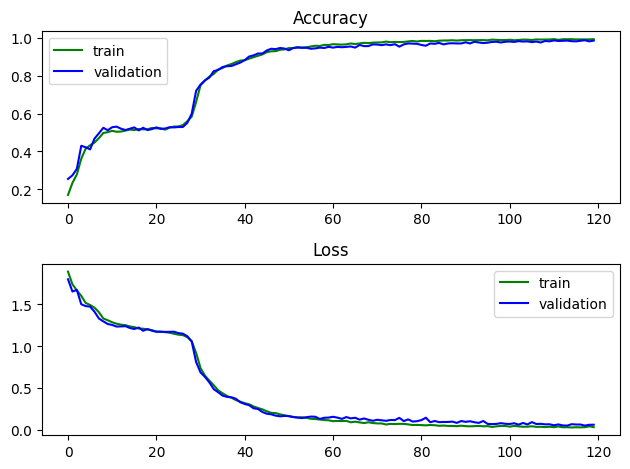

32/32 [==============================] - 0s 2ms/step


2023-12-18 14:34:26.766507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-18 14:34:26.767680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-18 14:34:26.768367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [37]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

ytest  = np.argmax(Ytest, axis=1)
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [141]:
N = len(test_data[0])
y = np.argmax(Ytest, axis=1)
p_proba = model.predict([Xstest, Xqtest])
p = np.argmax(Ytest_, axis=1)

idxs_true = np.where(y == p)[0]
idxs_false = np.where(y != p)[0]

n = 0
for idx in idxs_false:
    story    = test_data[0][idx]
    question = test_data[1][idx]
    answer   = test_data[2][idx]
    
    print("- Story:")
    for sent in story:
        print('\t' + sent)
    print("- Question:", question)
    print("- Answer:", answer)
    print("- Prediction:", idx2word[p[idx]])
    print("- Prediction:", dict(zip(word2idx, p_proba[idx][1:].round(4))))
    print()
    n += 1
    if n > 10:
        break

32/32 [==============================] - 0s 3ms/step
- Story:
	Sandra went to the office.
	Sandra travelled to the bathroom.
	Mary went back to the bedroom.
	Daniel moved to the garden.
	John journeyed to the garden.
	Daniel went back to the hallway.
- Question: Where is Sandra? 
- Answer: bathroom
- Prediction: bedroom
- Prediction: {'to': 0.0, 'the': 0.0, '.': 0.0, 'went': 0.0, 'Sandra': 0.0, 'John': 0.0, 'Daniel': 0.0, 'Mary': 0.0, 'travelled': 0.0, 'journeyed': 0.0, 'back': 0.0, 'bathroom': 0.0002, 'garden': 0.0004, 'hallway': 0.0016, 'moved': 0.0, 'office': 0.0042, 'kitchen': 0.0, 'bedroom': 0.9936, 'Where': 0.0, 'is': 0.0, '?': 0.0}

- Story:
	Daniel went to the garden.
	John travelled to the garden.
	John travelled to the bathroom.
	Mary went to the garden.
	Sandra moved to the kitchen.
	Sandra went back to the bedroom.
	John journeyed to the office.
	Sandra went to the office.
- Question: Where is Mary? 
- Answer: garden
- Prediction: bathroom
- Prediction: {'to': 0.0, 'the': 0

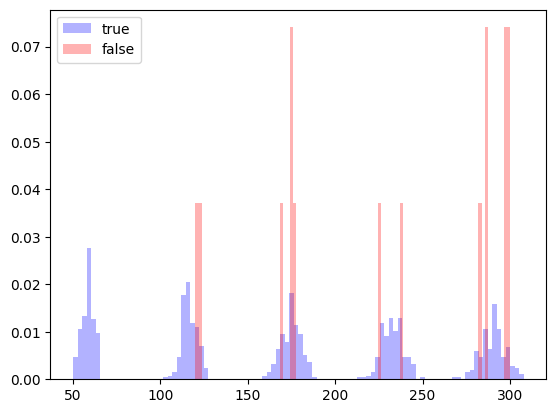

In [162]:
lens_true  = [len(''.join(test_data[0][idx])) for idx in idxs_true]
lens_false = [len(''.join(test_data[0][idx])) for idx in idxs_false]

plt.hist(lens_true,  bins=100, color='b', label='true', density=True, alpha=0.3)
plt.hist(lens_false, bins=100, color='r', label='false', density=True, alpha=0.3)
plt.legend();

In [165]:
y_true = [idx2word[y[idx]] for idx in idxs_true]
p_true = [idx2word[p[idx]] for idx in idxs_true]

y_false = [idx2word[y[idx]] for idx in idxs_false]
p_false = [idx2word[p[idx]] for idx in idxs_false]

In [194]:
len(idxs_true), len(idxs_false)

(985, 15)

<Axes: xlabel='p_false'>

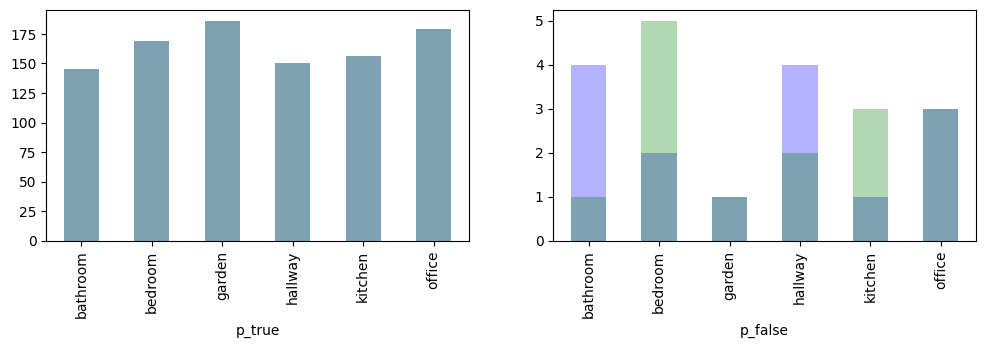

In [193]:
import pandas as pd

df_true  = pd.DataFrame({'y_true': y_true, 'p_true': p_true})
df_false = pd.DataFrame({'y_false': y_false, 'p_false': p_false})

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
df_true['y_true'].value_counts().sort_index().plot.bar(ax=axes[0], color='b', alpha=0.3)
df_true['p_true'].value_counts().sort_index().plot.bar(ax=axes[0], color='g', alpha=0.3)
df_false['y_false'].value_counts().sort_index().plot.bar(ax=axes[1], color='b', alpha=0.3)
df_false['p_false'].value_counts().sort_index().plot.bar(ax=axes[1], color='g', alpha=0.3)